# Spectral Resolution Tests

### Using synthetic spectra, how well can we determine wavelength and plate scale for TOLIMAN?

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline
import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
mpl.rcParams['font.size']=14               #10 
mpl.rcParams['savefig.dpi']= 200             #72 

import pysynphot as S

import specutils
from specutils.spectra import Spectrum1D
from astropy.io import fits as pyfits
from astropy.wcs import WCS
from astropy.io import fits
from scipy.ndimage.filters import gaussian_filter1d

INFO:root:Successfully loaded reader "cubetest1".
INFO:root:Successfully loaded reader "tabular-fits".
INFO:root:Successfully loaded reader "wcs1d-fits".


In [2]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)

In [34]:
wavels = np.linspace(3000,9000,50000)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)

## Let's plot some toy spectra

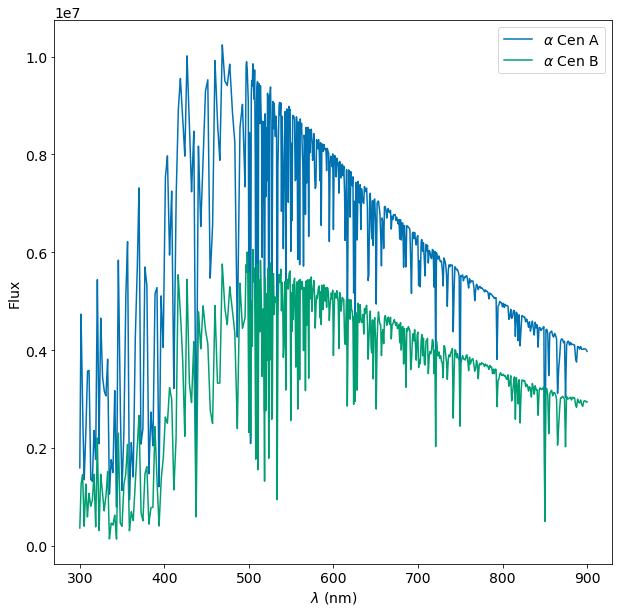

In [4]:
plt.plot(wavels/10.,specA,label=r'$\alpha$ Cen A')
plt.plot(wavels/10.,specB,label=r'$\alpha$ Cen B')
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.legend()

## For TOLIMAN let's assume optical properties of HST WFC3, with a 500-600 nm bandpass

In [31]:
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)

(4975, 5950)

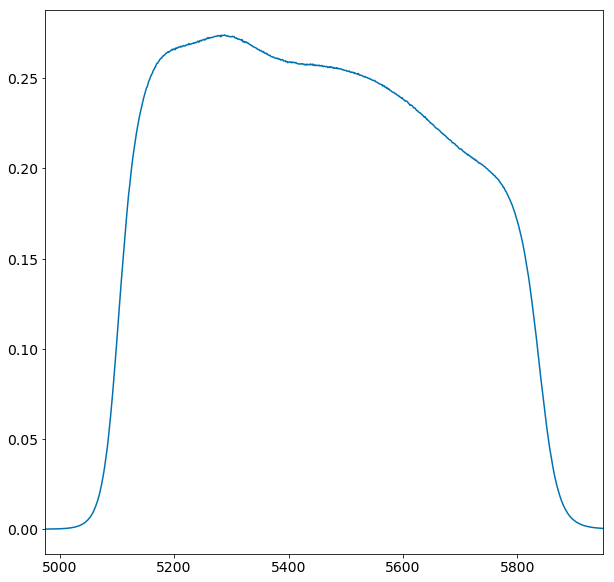

In [32]:
plt.plot(wavels,bandpass)
plt.xlim(4975,5950)

In [33]:
plt.plot(wavels,specA*bandpass)
plt.plot(wavels,specB*bandpass)

ValueError: operands could not be broadcast together with shapes (50000,) (1000,) 

There is a UVES tutorial at http://www.astropy.org/astropy-tutorials/UVES.html

### Now what we want to do is simulate the change in centroid as you scan in temperature

In [8]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= bandpass
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

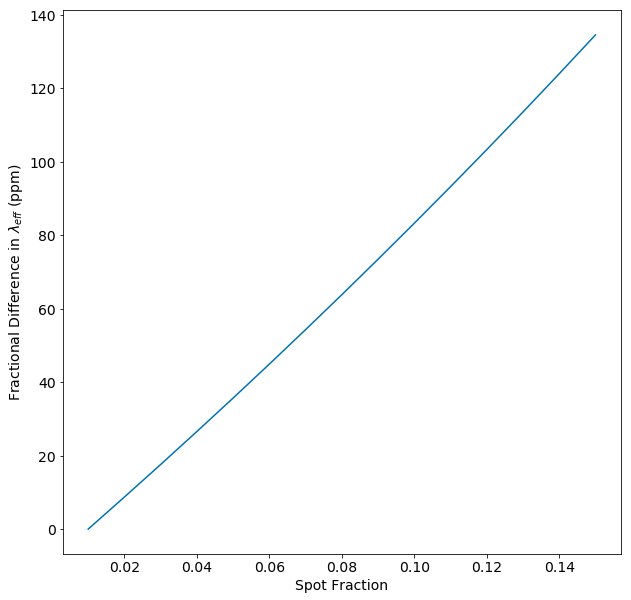

In [9]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### We want sub-ppm change in effective wavelength - let's try a narrower band?

In [35]:
nbp = S.ObsBandpass('wfc3,uvis1,f502n')
# nbp = S.ObsBandpass('wfc3,uvis1,f631n')
nbp = S.ObsBandpass('wfc3,uvis1,f645n')

narrow = nbp.sample(wavels)

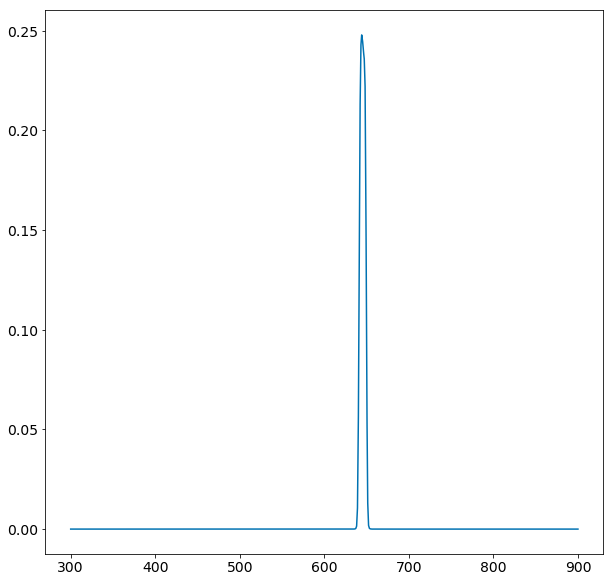

In [36]:
plt.plot(wavels/10.,narrow)
# plt.xlim(480,520)

In [12]:
T_surface = 5790
T_spot = 4700

fractions = np.linspace(0.01,0.15,15)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)

centres = []

for frac in fractions:
    this_spec = (1-frac)*surf_spec + (frac)*spot_spec
    this_spec *= narrow
    
    centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))
    
centres = np.array(centres)
diffs = (centres-centres[0])/centres[0]

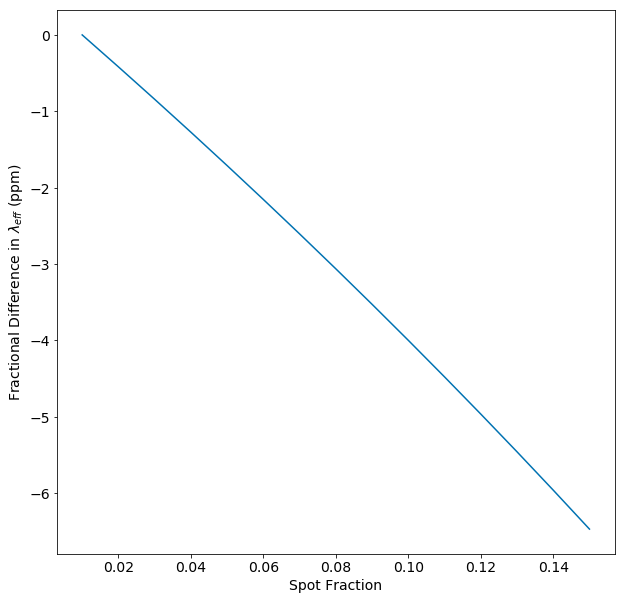

In [13]:
plt.plot(fractions,diffs*1e6)
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')

### So a 100 nm bandpass gives you ~ tens of ppm change in effective wavelength, but 10 nm gives you ~ a few ppm. It is better to put this in some spectral regions than others! 

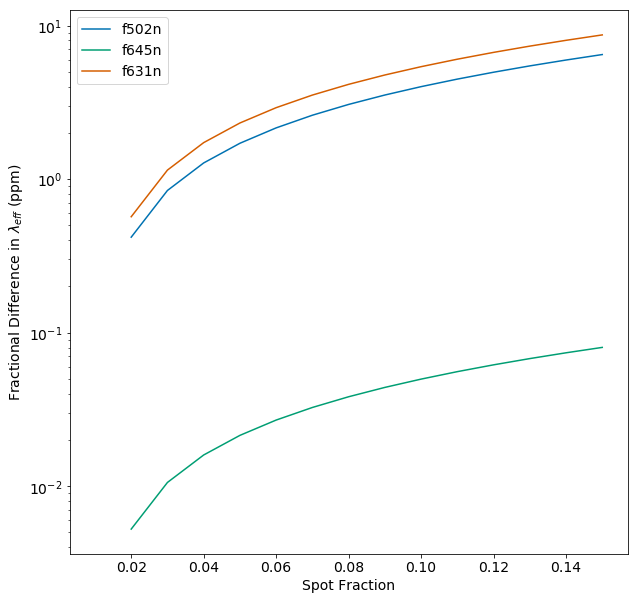

In [14]:
filters = ['f502n','f645n','f631n']

for filt in filters:
    
    nbp = S.ObsBandpass('wfc3,uvis1,%s'%filt)

    narrow = nbp.sample(wavels)
    
    centres = []

    for frac in fractions:
        this_spec = (1-frac)*surf_spec + (frac)*spot_spec
        this_spec *= narrow

        centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))

    centres = np.array(centres)
    diffs = np.abs((centres-centres[0])/centres[0])
    
    plt.semilogy(fractions,diffs*1e6,label=filt)
    
    
plt.xlabel('Spot Fraction')
plt.ylabel(r'Fractional Difference in $\lambda_{eff}$ (ppm)')
plt.legend()

# Now we want to see how well we can infer T_surface, T_spot, frac, and a scale! 

In [15]:
def model(T_surface,T_spot,frac,scale,wavels):
    surface = (1-frac)*S.Icat('phoenix',T_surface,0.2,4.30)
    spot = frac*S.Icat('phoenix',T_spot,0.2,4.30)
    spec = surface+spot
    spec.redshift(scale)
    return spec(wavels)


In [16]:
wavels = np.linspace(4975,5950,1000)
bp = S.ObsBandpass('wfc3,uvis1,f547m')
bandpass = bp.sample(wavels)


In [17]:
%%time

for j in range(50):
    data = model(T_surface,T_spot,0.15,0.,wavels)#*bandpass

CPU times: user 10.2 s, sys: 246 ms, total: 10.4 s
Wall time: 16.5 s


In [131]:
def supergaussian(wavels,centre,sigma=10):
    return np.exp(-((wavels-centre)/(sigma/2.))**8)

(5000, 5500)

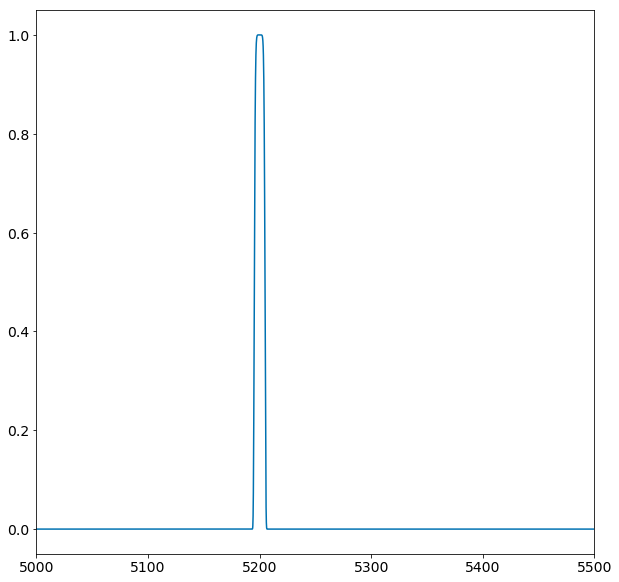

In [132]:
plt.plot(wavels,supergaussian(wavels,5200))
plt.xlim(5000,5500)

In [133]:
T_surface = 5790
T_spot = 4700

surf_spec = surface.sample(wavels)
spot_spec = spot.sample(wavels)
surface = S.Icat('phoenix',T_surface,0.2,4.30)
spot = S.Icat('phoenix',T_spot,0.2,4.30)

bands = np.linspace(5000,7000,500)
full_list = []
sigs = [10,50,100,250,500,1000]

for sig in sigs:
    grads = []

    for band in bands:
        bandpass = supergaussian(wavels,band,sigma=sig)

        centres = []

        for frac in [0.0,0.15]:
            this_spec = bandpass*((1-frac)*surf_spec + (frac)*spot_spec)

            centres.append(np.sum(wavels*this_spec)/np.sum(this_spec))

        centres = np.array(centres)
        diff = np.abs(centres[1]-centres[0])/centres[0]

        grads.append(diff)

    grads = np.array(grads)
    full_list.append(grads)

100.0


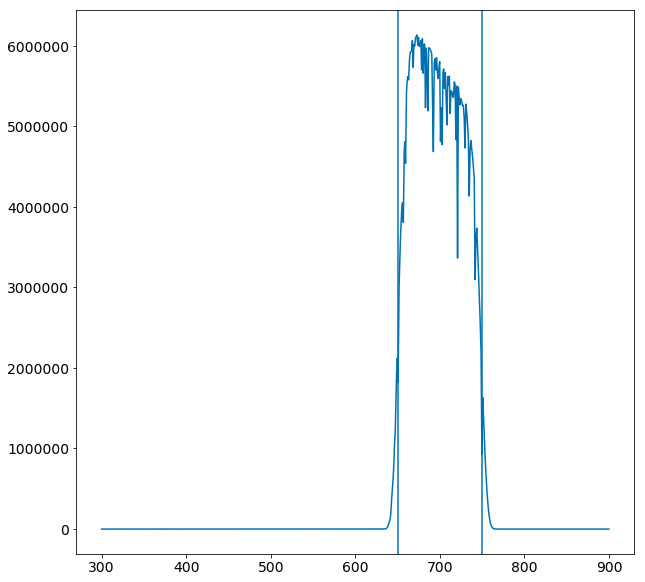

In [135]:
plt.plot(wavels/10.,this_spec)
print sig/10.
plt.axvline((band-sig/2.)/10)
plt.axvline((band+sig/2.)/10)

100
250
500
1000


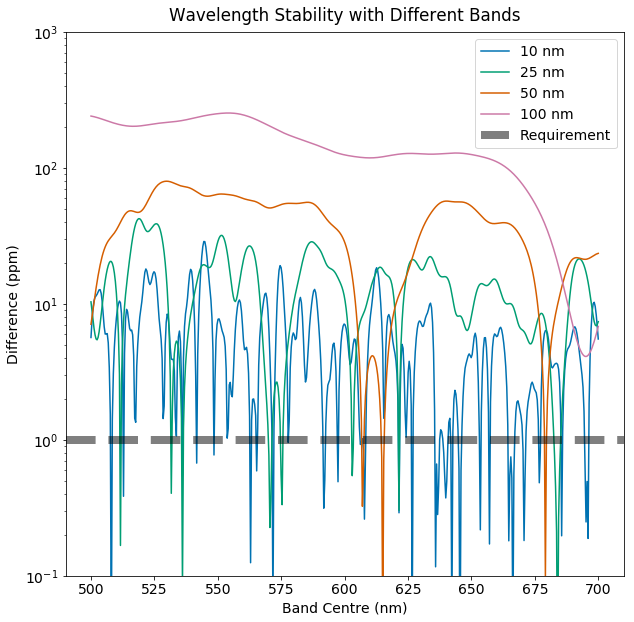

In [146]:
# for j, sig in enumerate(sigs):
for j in [2,3,4,5]:
    sig = sigs[j]
    print sig
    plt.semilogy(bands/10.,full_list[j]*1e6,label=('%d nm') % (sig/10.))
    
plt.axhline(1,ls='--',lw=8,alpha=0.5,label='Requirement',color='k')
plt.xlabel('Band Centre (nm)')
plt.ylabel('Difference (ppm)')
plt.legend(loc=1)
plt.title('Wavelength Stability with Different Bands',y=1.01)
plt.ylim(1e-1,1e3)
plt.savefig('bands.png')